# Imports

In [1]:
#export
import os
import sys
sys.path.append(os.path.join(os.getcwd(),'exp'))

import json
import yaml
import datetime
import collections
from pathlib import Path
from collections import OrderedDict

import numpy as np
import pandas as pd
from nb_base_exp import *#BaseExperiment, BaseProject, load_txt_log
from config import cfg

In [2]:
import plotly.express as px
import shutil
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

# Code

In [4]:
#export
def load_log(path):
    columns = ['date','epoch','acc','val_acc']
    types = [str, np.int32, np.float32, np.float32]
    log_path = list(path.rglob('*/*/log.txt'))[0]

    _, logs = load_txt_log(path=log_path, types=types)

    df = pd.DataFrame(logs, columns=columns)
    df.dropna(inplace=True)
    df = df.astype(dict(zip(columns, types)))

    df['val_acc'].replace(-1., np.NaN, inplace=True)
    df.fillna(method='ffill', inplace=True)
    df.set_index('epoch', inplace=True)
    timeDF=(pd.to_datetime(df['date'].str.strip(), format='%H:%M:%S'))
    del df['date']# = timeDF
    df['duration'] = timeDF - timeDF[0]
    return df

def load_yaml_cfg(path):
    params_path = list(path.rglob('*/*/train.yaml'))[0]
    with open(params_path, 'r') as f:
        d = yaml.safe_load(f)
    d = flatten(d, sep='|')
    d = OrderedDict(sorted(d.items(), key=lambda x:x[0], reverse=False))
    return d

def load_json_cfg(path):
    params_path = list(path.rglob('*/*/params.json'))[0]
    with open(params_path, 'r') as f:
        d = json.load(f)
    d = flatten(d, sep='|')
    d = OrderedDict(sorted(d.items(), key=lambda x:x[0], reverse=False))
    return d

def load_cfg(*args, **kwargs):
    return load_json_cfg(*args, **kwargs)

def check_valid(cpath):
    flag_files = set(['log.txt', 'params.json'])
    where_to_look = 'output'
    output = list(Path(cpath).rglob(where_to_look))
    files=[]
    if output:
        files = list(output[0].glob('*/*'))

    return flag_files.issubset(set([f.name for f in files]))



In [5]:
#export
class GenExperiment(BaseExperiment):
    def __init__(self,  path):
        super(GenExperiment, self).__init__(path, log_reader=load_log, cfg_reader=load_cfg)
        self.start_time = self.parse_name()

    def parse_name(self, prefix='run_'):
        date = self.name.strip(prefix)#.rstrip('.lock')
        start_time = datetime.datetime.strptime(date, '%Y_%b_%d_%H_%M_%S_%f')
        return start_time

    def total_time(self):
        return self.log_data['duration'][self.__len__()-1]
    
class GenProject(BaseProject):
    def __init__(self,  root):
        super(GenProject, self).__init__(root, valid_func=check_valid, Experiment=GenExperiment)
    
    def extend_base(self):
        dd = {}
        for run in self.exps:
            run_best = run.best(num=3, col='val_acc')
            #run_best_pct = 100 - int( 100 * (run.total_time() - dur) / run.total_time())
            d = {}
            d['start'] = run.start_time
            d['name'] = run.name
            d['tt'] = run.total_time()
            d['t2b'] = run_best['duration'].values[0]
            d['ba'] = round(run_best.mean()[['acc']].values[0],3)
            d['bva'] = round(run_best.mean()[['val_acc']].values[0],3)
            d['la'] = round(run.log_data['acc'][-10:].mean(),3)
            #d.update(**run.params)
            dd[run.name] = d
        #res_df = pd.DataFrame(results, columns=['Name','duration', 'LRM', 'best_acc', 'best_val', 'best_pct', *run.params.keys()])

        df = pd.DataFrame(dd).T
        df = pd.concat([df,self.base_table()], axis=1)
        df.set_index('start', drop=True, inplace=True)
#         for x in ['tt','t2b']:
#             df[x] = pd.DatetimeIndex(df[x]).strftime("%H:%M:%S")
            
        df['ba'] = df['ba'].astype(float)
        df['la'] = df['la'].astype(float)
        df['bva'] = df['bva'].astype(float)
        df = df.round(4)
        
        
        return df

In [6]:
def plot(cols=None, window=1,limits=[-1,-1], ax=None, x=None):
        if ax is None:
            f,ax = plt.subplots(1)
        if cols is None:
            cols = ['acc']
        if x is not None:
            cols.append(x)
            
        data = e.log_data
        llim, rlim = limits
        rlim = len(data) if rlim <=0 else rlim
        llim = max(0, llim)
        
        
        d = data.iloc[llim:rlim,:]
        d = d.loc[:,cols]
        for c in cols:
            if c != 'duration':
                d[c] = d[c].rolling(window).mean() 
        
        d.plot(figsize=(12,7), ax=ax, x=x)
        
def mod_df(df, col='acc', window=1, div=1):
    d = df.loc[:, [col, 'duration']]
    s = d['duration'].apply(lambda x: x.seconds)/div
    d.loc[:,'duration'] = s
    
    s = d[col].rolling(window).mean()
    d.loc[:,col] = s
    return d

def plot_run(run, col, ax,  window=5):
    d = mod_df(run.log_data, col=col, window=window)
    d.plot('duration', ax=ax)

# Tests

In [28]:
root = Path(cfg.DAG.RUNS)
#root = Path('../__crsch_cycle/cycler_runs/')

bp = GenProject(root)
df = bp.extend_base()

In [29]:
#df.sort_index(ascending=False).head(5)
df.drop(['name'], axis=1).sort_values('bva', ascending=False).head(10)

,tt,t2b,ba,bva,la,dec_f0,dec_f1,dec_f2,dec_f3,generation_size,generations,genom|combine_chance,genom|crossover_chance,genom|mutate_chance,post|exp_power,seed,subsample_size
start,,,,,,,,,,,,,,,,,
2020-05-21 20:02:47.284131,00:07:06,00:06:32,0.584,0.584,0.589,12,10,8,6,200,200,0.4910,1.0000,0.0021,6,0,50
2020-05-21 20:18:09.435122,00:07:23,00:07:23,0.574,0.582,0.578,12,10,8,6,200,200,0.5610,1.0000,0.0031,15,0,50
2020-05-21 20:10:27.642756,00:07:11,00:07:11,0.566,0.580,0.565,12,10,8,6,200,200,0.5049,0.9578,0.0035,15,0,50
2020-05-21 19:31:28.669589,00:07:02,00:06:01,0.582,0.580,0.585,12,10,8,6,200,200,0.5056,1.0000,0.0038,9,0,50
2020-05-21 19:39:01.593122,00:07:07,00:06:11,0.590,0.578,0.599,12,10,8,6,200,200,0.4910,1.0000,0.0021,6,0,50
2020-05-21 18:17:42.597546,00:07:04,00:06:34,0.595,0.574,0.589,12,10,8,6,200,200,0.4932,0.8889,0.0029,5,0,50
2020-05-21 19:31:29.329349,00:07:05,00:07:05,0.592,0.574,0.591,12,10,8,6,200,200,0.4965,0.8912,0.0035,4,0,50
2020-05-21 18:25:49.148309,00:07:03,00:05:44,0.552,0.573,0.554,12,10,8,6,200,200,0.4932,0.8889,0.0029,5,0,50
2020-05-21 18:52:46.945772,00:07:07,00:06:28,0.554,0.565,0.562,12,10,8,6,200,200,0.4749,1.0000,0.0000,1,0,50


0.4655833333333333


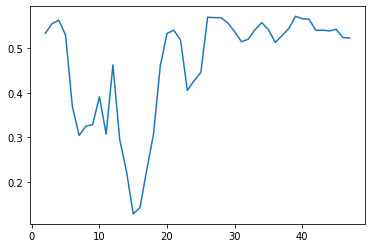

In [30]:
s = df['bva']
print(s.mean())
s = s.sort_index()
plt.plot(s.rolling(3).mean().values)

In [12]:
df['tt'].sum()

Timedelta('0 days 01:04:32')

In [110]:
# df = df[df['ba']>.3]
# df.shape

In [111]:
# df = df[df['crossover_chance']==1.99]
# df.shape
# names = df.sort_index()['name'][:30].values
# p = Path('../__crsch_cycle/cycler_runs/')
# for name in names:
#     pi = p/name
#     shutil.rmtree(pi)

In [26]:
df

,name,tt,t2b,ba,bva,la,dec_f0,dec_f1,dec_f2,dec_f3,generation_size,generations,genom|combine_chance,genom|crossover_chance,genom|mutate_chance,post|exp_power,seed,subsample_size
start,,,,,,,,,,,,,,,,,,
2020-05-21 20:02:47.284131,run_2020_May_21_20_02_47_284131,00:07:06,00:06:32,0.584,0.584,0.589,12,10,8,6,200,200,0.4910,1.0000,0.0021,6,0,50
2020-05-21 20:10:27.505601,run_2020_May_21_20_10_27_505601,00:07:00,00:06:32,0.498,0.499,0.496,12,10,8,6,200,200,0.8644,0.7478,0.0133,2,0,50
2020-05-21 18:33:16.465347,run_2020_May_21_18_33_16_465347,00:06:58,00:03:31,0.318,0.377,0.348,12,10,8,6,200,200,0.0000,1.0000,0.0500,15,0,50
2020-05-21 18:17:42.590034,run_2020_May_21_18_17_42_590034,00:07:02,00:04:34,0.540,0.550,0.537,12,10,8,6,200,200,0.4790,0.6761,0.0158,15,0,50
2020-05-21 18:25:49.043700,run_2020_May_21_18_25_49_043700,00:07:05,00:07:05,0.551,0.543,0.536,12,10,8,6,200,200,0.4790,0.6761,0.0158,15,0,50
2020-05-21 19:31:28.669589,run_2020_May_21_19_31_28_669589,00:07:02,00:06:01,0.582,0.580,0.585,12,10,8,6,200,200,0.5056,1.0000,0.0038,9,0,50
2020-05-21 20:48:42.842450,run_2020_May_21_20_48_42_842450,00:04:41,00:03:11,0.552,0.529,0.507,12,10,8,6,200,200,0.3465,0.7689,0.0139,15,0,50
2020-05-21 19:15:12.332683,run_2020_May_21_19_15_12_332683,00:07:08,00:07:08,0.460,0.493,0.492,12,10,8,6,200,200,0.4779,1.0000,0.0114,1,0,50
2020-05-21 19:07:45.774795,run_2020_May_21_19_07_45_774795,00:07:03,00:07:03,0.110,0.104,0.110,12,10,8,6,200,200,0.7081,1.0000,0.0451,1,0,50


In [27]:
k = 'bva'
tdf = df.sort_index(ascending=False)#[:80]
fig = px.parallel_coordinates(tdf, color=k,
              dimensions=['genom|combine_chance', 'genom|crossover_chance', 'genom|mutate_chance', 'post|exp_power',
                         #'dec_f0','dec_f1','dec_f2','dec_f3',
                          'bva'],
              color_continuous_scale=px.colors.diverging.Tealrose,
              range_color=[0.45,df[k].max()],
              color_continuous_midpoint=.5)
fig.show()

In [20]:
plot_df = df[:1]
top = df.sort_values(by='bva', ascending=False)[:50]
plot_df = pd.concat([plot_df,top])

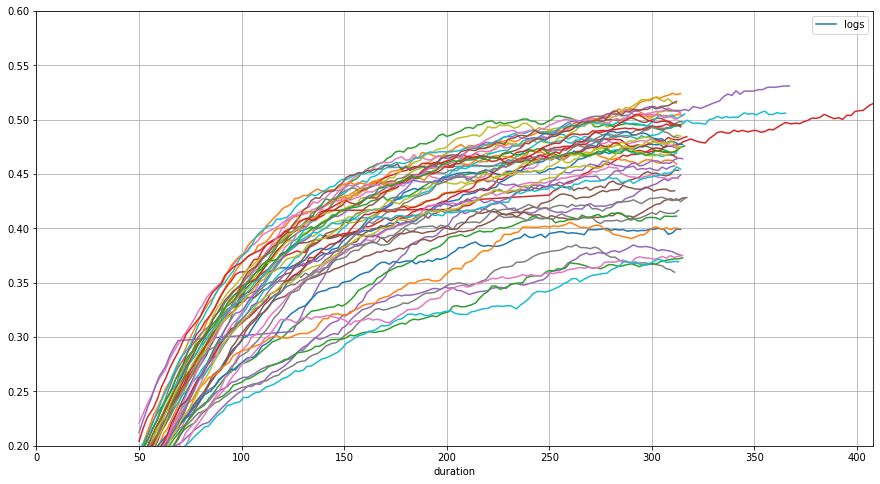

In [21]:
rs = bp.exps
f, a = plt.subplots(1, figsize=(15,8))
#l_lim, r_lim = 0, 1000

rsp = [r for r in rs if r.name in plot_df.name.values]

[plot_run(r, col='acc', ax=a, window=25) for r in rsp]

#a.legend([r.name for r in rsp])
a.legend(['logs'])

#a.set_xticks(np.arange(l_lim, 700, 10))
#a.set_yticks(np.arange(0.1, .9, 0.05))
plt.ylim(0.2,.6)
plt.grid()

# More tests

In [7]:
root = Path('./results/bo3/')
bp = GenProject(root)
df = bp.extend_base()

In [8]:
df.sort_values('bva', ascending=False).head(5)

,name,tt,t2b,ba,bva,la,combine_chance,crossover_chance,dec_f0,dec_f1,dec_f2,dec_f3,exp_power,generation_size,generations,mutate_chance,seed,subsample_size
start,,,,,,,,,,,,,,,,,,
2020-05-20 21:55:34.700110,run_2020_May_20_21_55_34_700110,00:05:15,00:05:15,0.597,0.578,0.592,0.5537,0.990,12,10,8,6,3,200,150,0.0029,0,50
2020-05-20 22:24:27.214092,run_2020_May_20_22_24_27_214092,00:05:16,00:04:36,0.552,0.570,0.572,0.4029,0.990,12,10,8,6,4,200,150,0.0030,0,50
2020-05-20 22:24:45.857274,run_2020_May_20_22_24_45_857274,00:05:17,00:05:17,0.575,0.569,0.549,0.6316,0.990,12,10,8,6,4,200,150,0.0027,0,50
2020-05-20 22:12:56.170186,run_2020_May_20_22_12_56_170186,00:05:14,00:05:14,0.591,0.554,0.575,0.3108,0.729,12,10,8,6,15,200,150,0.0055,0,50
2020-05-20 22:30:45.146955,run_2020_May_20_22_30_45_146955,00:05:19,00:05:19,0.571,0.553,0.547,0.1315,0.990,12,10,8,6,15,200,150,0.0097,0,50


In [9]:
df.shape

(52, 18)

In [92]:
class HyperSet:
    def  __init__(self, cfg, param_list, target):
        self.cfg = cfg
        self.params = param_list
        self.target = target
        
    def read_cfg(self, map_names):
        if map_names is None: map_names = {p:p for p in self.params}
            
        points = {}
        for p in self.params:
            p_mapped = map_names[p]
            points[p_mapped] = self.cfg[p]
        return points
    
    def create_record(self, map_names=None):
        return {
            'points':self.read_cfg(map_names),
            'target':self.target
        }

In [11]:
base_e = bp.exps[0]
base_e.cfg_data

OrderedDict([('combine_chance', 0.8596846670092858),
             ('crossover_chance', 0.99),
             ('dec_f0', 12),
             ('dec_f1', 10),
             ('dec_f2', 8),
             ('dec_f3', 6),
             ('exp_power', 7),
             ('generation_size', 200),
             ('generations', 150),
             ('mutate_chance', 0.00039690221562281493),
             ('seed', 0),
             ('subsample_size', 50)])

In [28]:
from exp.nb_base_exp import flatten

In [208]:
pairs = [('TRAIN|DS', ['data1']), ('TRAIN|LR',1e-5), ('MODEL|ARCH|n1', 8)]
sep = '|'

d = {}
for p in pairs:
    di = create_nested(defaultdict(dict), *p)
    dict_merge(d, di)
d

{'TRAIN': {'DS': ['data1'], 'LR': 1e-05}, 'MODEL': {'ARCH': {'n1': 8}}}

In [72]:
with open('./train.yaml', 'r') as f:
    d = yaml.safe_load(f)

In [73]:
flat_d = flatten(d, sep='|')

In [85]:
k, v = list(flat_d.items())[17]
k, v

('TRAIN|BASE_LR', 0.0001)

In [91]:
with open('./train_mod.yaml', 'w') as f:
    yaml.safe_dump(d, f)

In [30]:
bo_params = ['combine_chance', 'crossover_chance', 'mutate_chance']
lat_names = ['cc', 'cr','mc']
map_names = dict(zip(bo_params,lat_names))

bo_target = 'val_acc'

hps = []
for e in bp.exps:
    target = e.log_data[bo_target].max()
    cfg = e.cfg_data
    hp = HyperSet(cfg, bo_params, target)
    rec = hp.create_record(map_names)
    hps.append(rec)


In [31]:
hps

[{'points': {'cc': 0.8596846670092858,
   'cr': 0.99,
   'mc': 0.00039690221562281493},
  'target': 0.5218545198440552},
 {'points': {'cc': 0.779673498777105, 'cr': 0.99, 'mc': 0.0008768820860711135},
  'target': 0.5483208894729614},
 {'points': {'cc': 0.894775653998578, 'cr': 0.99, 'mc': 0.005888451865490507},
  'target': 0.5455100536346436},
 {'points': {'cc': 0.5536945866460486, 'cr': 0.99, 'mc': 0.002871006891225743},
  'target': 0.5779703259468079},
 {'points': {'cc': 0.6985920925954717,
   'cr': 0.07041869717793878,
   'mc': 0.0072821697698758694},
  'target': 0.48712921142578125},
 {'points': {'cc': 0.17721367618202588,
   'cr': 0.873222452225672,
   'mc': 0.03553158253794306},
  'target': 0.11625593900680542},
 {'points': {'cc': 0.11517998947166638, 'cr': 0.99, 'mc': 0.0314730450392788},
  'target': 0.4411870241165161},
 {'points': {'cc': 0.933835609657577, 'cr': 0.01, 'mc': 0.01406457549130841},
  'target': 0.4906202554702759},
 {'points': {'cc': 0.09175272511470739,
   'cr': 

In [33]:
hp_warm = []
for e in bp.exps:
    target = e.log_data[bo_target].max()
    points = {}
    for p in bo_params:
        points[p] = e.cfg_data[p]
    hp_warm.append({'target': target,
                    'points': points})

In [34]:
hp_warm

[{'target': 0.5218545198440552,
  'points': {'combine_chance': 0.8596846670092858,
   'crossover_chance': 0.99,
   'mutate_chance': 0.00039690221562281493}},
 {'target': 0.5483208894729614,
  'points': {'combine_chance': 0.779673498777105,
   'crossover_chance': 0.99,
   'mutate_chance': 0.0008768820860711135}},
 {'target': 0.5455100536346436,
  'points': {'combine_chance': 0.894775653998578,
   'crossover_chance': 0.99,
   'mutate_chance': 0.005888451865490507}},
 {'target': 0.5779703259468079,
  'points': {'combine_chance': 0.5536945866460486,
   'crossover_chance': 0.99,
   'mutate_chance': 0.002871006891225743}},
 {'target': 0.48712921142578125,
  'points': {'combine_chance': 0.6985920925954717,
   'crossover_chance': 0.07041869717793878,
   'mutate_chance': 0.0072821697698758694}},
 {'target': 0.11625593900680542,
  'points': {'combine_chance': 0.17721367618202588,
   'crossover_chance': 0.873222452225672,
   'mutate_chance': 0.03553158253794306}},
 {'target': 0.4411870241165161,


# Exports

In [11]:
!python3 extra/n2s.py gen_exp.ipynb 

Converted gen_exp.ipynb to exp/nb_gen_exp.py
